## Imports

In [115]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pycountry
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy
import warnings
from func_library import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)
# pd.options.display.float_format = '{:.0f}'.format
np.random.seed(42)

## Reading (Run Once)

In [2]:
stack_overflow, skills_list, employments = StackOverflowData.generate_aggregate_df()
salaries = AISalariesData.generate_df()
ppp = read_ppp()
ppp.index = ppp["country"]
ppp = ppp.drop_duplicates(subset='country', keep='last')
ppp = ppp.drop(["country", "country_full_name"], axis=1)
ppp = ppp.replace({"no data": np.nan})
ppp = ppp.ffill(axis=1)
ppp = ppp.astype(float)

In [ ]:
# adjust for inflation
stack_overflow["convertedcompyearly"] = stack_overflow.apply(lambda row: adjust_usd_to_2023_usd(row["comptotal"], row["year"]), axis=1)
salaries["salary_in_usd"] = salaries.apply(lambda row: adjust_usd_to_2023_usd(row["salary"], str(row["work_year"])), axis=1)

# adjust for PPP
stack_overflow = stack_overflow[~stack_overflow["country"].isin(["CUB", "IMN", "PSE", "PRK"])]
stack_overflow["convertedcompyearly"] = stack_overflow.apply(
    lambda row: row["convertedcompyearly"]  * float(ppp.loc[row["country"], row["year"]]),
    axis=1
)
salaries = salaries[~salaries["company_location"].isin(["GIB", "ASM"])]
salaries["salary_in_usd"] = salaries.apply(
    lambda row: row["salary_in_usd"]  * float(ppp.loc[row["company_location"], str(row["work_year"])]),
    axis=1
)

In [116]:
stack_overflow, skills_list, employments = StackOverflowData.generate_aggregate_df(only_data_science_devs=True)
exchange_rate_df = generate_exchange_rates_df()
ppp_df = read_ppp()
stack_overflow = StackOverflowData.generate_2023_usd_comp(stack_overflow, exchange_rate_df, ppp_df)

ai_salaries_df = AISalariesData.generate_df()
ai_salaries_df = AISalariesData.generate_2023_usd_comp(ai_salaries_df, exchange_rate_df, ppp_df)
ai_salaries_df['usd_2023'].describe()

ai_salaries_df = ai_salaries_df.dropna(subset=['usd_2023'])
stack_overflow = stack_overflow.dropna(subset=['usd_2023'])

NameError: name 'generate_exchange_rates_df' is not defined

## Analysis

In [109]:
# more workable until we go by skills
s_o = stack_overflow.drop(skills_list, axis=1)
# list(s_o.columns)

In [110]:
salaries.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [114]:
s_o

,mainbranch,sopartfreq,socomm,soaccount,yearscodepro,age,surveyease,country,orgsize,convertedcompyearly,year,original_country,comptotal,employment,count,surveylength,yearscode,edlevel,sovisitfreq,analyst,data scientist,developer,engineer_other,management,scientist_other,systems_architect
2,"I am not primarily a developer, but I write co...",Multiple times per day,Neutral,Yes,5,25-34 years old,Neither easy nor difficult,GBR,20 to 99 employees,22083.20,2022,United Kingdom of Great Britain and Northern I...,32000.0,"Employed, full-time",1,Appropriate in length,14,Master's,Multiple times per day,0,1,1,1,0,0,0
5,"I am not primarily a developer, but I write co...",I have never participated in Q&A on Stack Over...,"No, not really",Yes,3,25-34 years old,Neither easy nor difficult,CAN,nan,56786.80,2019,Canada,40000.0,Employed full-time,1,Too long,13,Bachelor's,A few times per month or weekly,1,1,0,1,0,0,1
8,I am a developer by profession,Less than once per month or monthly,"Yes, somewhat",Yes,4,18-24 years old,Neither easy nor difficult,NZL,10 to 19 employees,239596.98,2019,New Zealand,138000.0,Employed full-time,1,Appropriate in length,12,Some College,Daily or almost daily,0,0,1,0,0,0,1
9,I am a developer by profession,A few times per month or weekly,"Yes, somewhat",Yes,10,nan,Difficult,IND,"10,000 or more employees",23821896.00,2019,India,950000.0,Employed full-time,1,Too long,12,Master's,Multiple times per day,1,1,1,0,0,0,1
9,I am a developer by profession,A few times per month or weekly,"Yes, somewhat",Yes,10,nan,Difficult,IND,"10,000 or more employees",23821896.00,2019,India,950000.0,Employed full-time,1,Too long,12,Master's,Multiple times per day,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88818,I am a developer by profession,Less than once per month or monthly,"No, not at all",Yes,10,25-34 years old,Easy,USA,"10,000 or more employees",175000.00,2023,United States of America,175000.0,"Employed, full-time",1,Appropriate in length,15,Master's,Daily or almost daily,0,0,0,1,0,0,0
88886,I am a developer by profession,Daily or almost daily,"Yes, definitely",Yes,3,35-44 years old,Neither easy nor difficult,USA,"10,000 or more employees",150000.00,2023,United States of America,150000.0,"Employed, full-time",1,Too long,15,Professional,Multiple times per day,0,1,0,0,0,0,0
88986,I am a developer by profession,Less than once per month or monthly,Neutral,Yes,9,25-34 years old,Easy,AUS,"1,000 to 4,999 employees",265500.00,2023,Australia,180000.0,"Employed, full-time",1,Appropriate in length,9,Bachelor's,A few times per week,0,0,0,1,0,0,0
89057,I am a developer by profession,NaN,"Yes, somewhat",Not sure/can't remember,7,25-34 years old,Neither easy nor difficult,USA,"10,000 or more employees",150000.00,2023,United States of America,150000.0,"Employed, full-time",1,Appropriate in length,10,Master's,A few times per month or weekly,0,0,0,1,0,0,0


#### Helper Functions

In [5]:
def get_similar_countries(df: pd.DataFrame, want: int = 10) -> list:
    """
    Get the number of countries that we want so we can index for ANOVA
    Consistent across the years for a good comparison
    """
    groupped = df.groupby('year')
    loc_list = list()
    head = 1
    
    while len(loc_list) < want:
        loc_set = set()
        for year, frame in groupped:
            grouped = frame.groupby("country").size().sort_values(ascending=False)
            if not loc_set:
                loc_set = set(grouped.head(head).index)
                continue
            temp_set = set(grouped.head(head).index)
            loc_set = loc_set.intersection(temp_set)
        loc_list = list(loc_set)
        head += 1
    return loc_list

### Is there a significant (statistical) difference between salaries in countries?
- When we remove outliers what happens?
- Do we see a trend in outliers?
- Can we break down what we see in the two or three highest salary countries?

In [6]:
loc_so = s_o[["year", "country", "convertedcompyearly"]]
loc_so.loc[:, "year"] = loc_so.loc[:, "year"].astype('int64')

loc_sal = salaries[["work_year", "employee_residence", "salary_in_usd"]]
loc_sal.loc[:, "salary_in_usd"] = loc_sal.loc[:, "salary_in_usd"].astype("float64")
loc_sal.columns = loc_so.columns


location = pd.concat([loc_so, loc_sal], ignore_index=True)
location

,year,country,convertedcompyearly
0,2022,GBR,2.774547e+04
1,2019,CAN,5.201955e+05
2,2019,NZL,1.652507e+05
3,2019,IND,3.333310e+05
4,2019,IND,3.333310e+05
...,...,...,...
65164,2020,USA,4.861600e+05
65165,2021,USA,1.661000e+05
65166,2020,USA,1.239000e+05
65167,2020,USA,1.180000e+05


### Side Quest: Outliers

Whats the story on the outliers?
- is it an outlier that started a trend and we see more?
- is it an oddity?

Hiking analogy
- go high level, then take a step down and keep going down
- go onto the next subject
- like for us go down to specific countries and specific analysis
- not only for the narrative, but what the data can tell us

In [7]:
IQR = location["convertedcompyearly"].quantile(0.75) - location["convertedcompyearly"].quantile(0.25)
q3 = location["convertedcompyearly"].quantile(0.75)
outliers = location[location['convertedcompyearly'] > q3 + (1.5*IQR)]
print(f"Outliers: {len(outliers)} vs. Normal: {len(location)}")

Outliers: 10081 vs. Normal: 65169


In [8]:
outliers = outliers.sort_values("convertedcompyearly", ascending=False)

<Axes: >

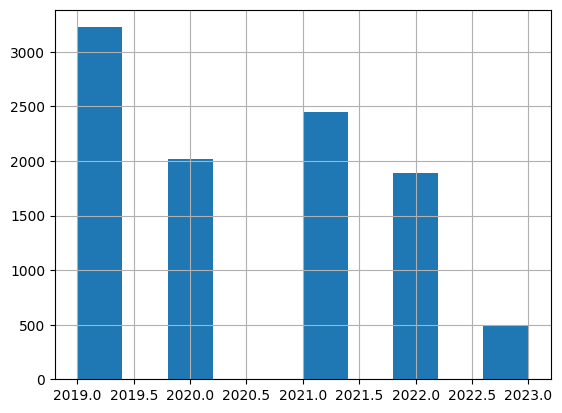

In [9]:
outliers["year"].hist()

We can see trend with the pandemic. We see people losing their jobs, then slow beings to self correct. Though, there may still be some trolling due to a max value of like \$50,000,000 somewhere within the outliers.

In [10]:
# outliers.groupby("country").agg(
#     count=('year', "size"), 
#     mean=('convertedcompyearly', 'mean'), 
#     median=('convertedcompyearly', 'median'),
#     std=('convertedcompyearly', 'std')
# )

<Axes: >

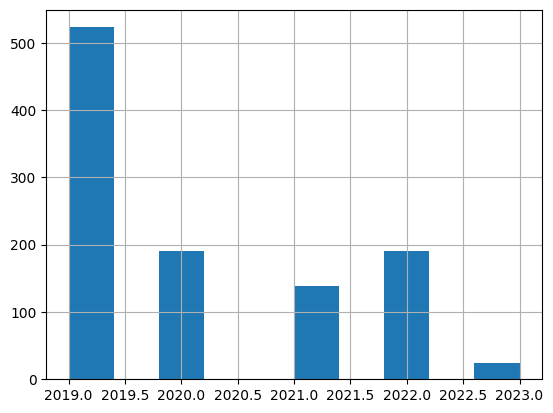

In [11]:
outliers_usa = outliers[outliers["country"] == "USA"]
outliers_usa["year"].hist()

In [12]:
adjust_usd_to_2023_usd

<function func_library.adjust_usd_to_2023_usd(old_usd: float, year: str) -> float>

### Back to location

In [13]:
location = location[location['convertedcompyearly'] < q3 + (1.5*IQR)]
countries = get_similar_countries(location, 20)

In [14]:
groupped = location.groupby("year")

In [15]:
dfs = []
for year, frame in groupped:
    t_tests = np.zeros((len(countries), len(countries)))
    frame = frame[frame["country"].isin(countries)]
    for i in range(len(countries)):
        control = countries[i]
        for j in range(i+1, len(countries)):
            exp = countries[j]
            d1 = frame[frame["country"] == control]
            d2 = frame[frame["country"] == exp]
            result = pg.ttest(d1.convertedcompyearly, d2.convertedcompyearly).round(3) # this is 2 tailed
            t_tests[j, i] = result.loc["T-test", "p-val"]
    df = pd.DataFrame(t_tests, columns=countries, index=countries)
    dfs.append(df)

In [16]:
# not a heatmap for value
# is everything kind of moving? do relationships stay throughout the years?
# # better visualization?
# fabricated metric? see correlation between the years
# # comprehensive view of this
# heatmap works for all the years into a single metric with the heat map
# growth rate between year
# collapse data set and get deltas from start to end
# # in between years and see correlations between growth
# fig, axes = plt.subplots(5, 1, figsize=(6, 25))
# for i in range(len(dfs)):
#     sns.heatmap(dfs[i], ax=axes[i])
# # plt.show()

In [17]:
from collections import defaultdict

# year{{country : {country: num}}}
stat_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
year = 2019

for df in dfs:
    for start in range(len(df)):
        r = start
        c = 0
        dec_row = False
        while c < len(df) and r < len(df):
            
            if r == c: # then we are on the diagonal
                dec_row = True
                r += 1
                continue

            row = df.index[r]
            col = df.columns[c]
            
            if df.iloc[r, c] < 0.05:
                val = 1
            else:
                val = 0
                    
            if not dec_row: # we are going across
                stat_counts[str(year)][row][col] = val
                c += 1
            else:
                stat_counts[str(year)][col][row] = val
                r += 1
    year += 1

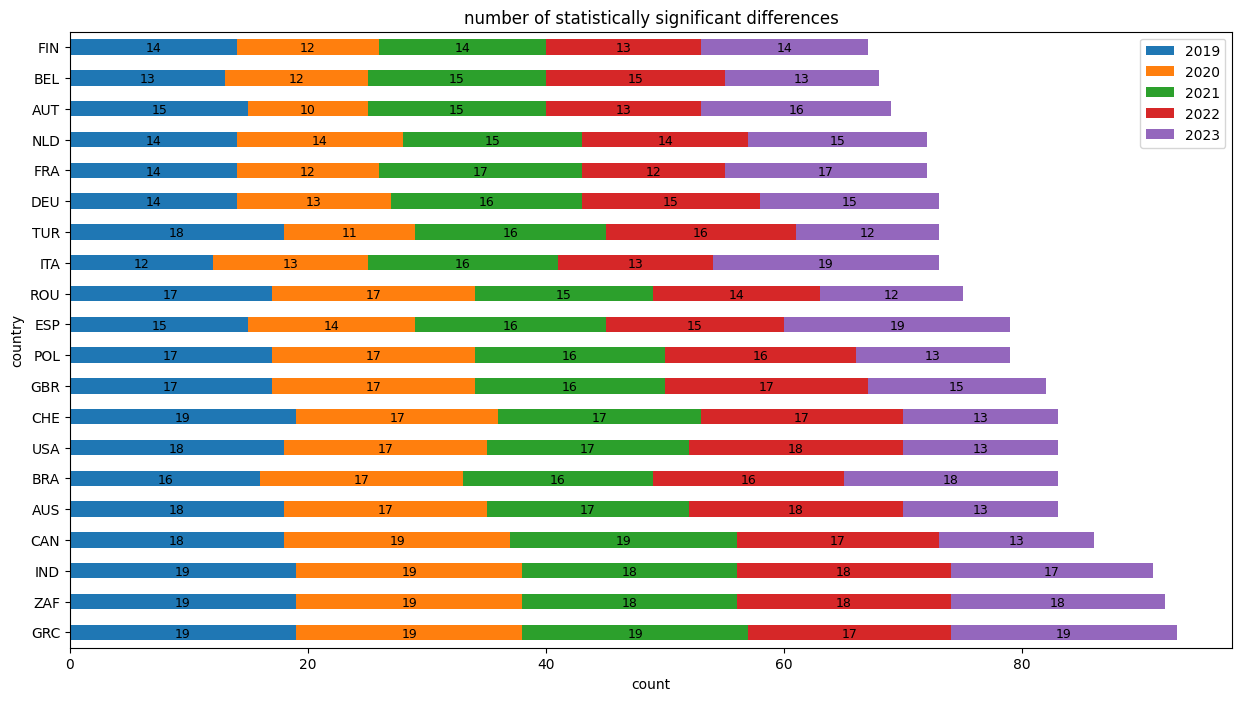

In [18]:
# {year: {country : {country: num}}}
result = {}
for year, count_dict in stat_counts.items():
    counts = [] 
    for key, value in count_dict.items():
        counts.append((key, sum(value.values())))
    result[year] = counts

transformed_data = {}
for key, tuples in result.items():
    for tup in tuples:
        index, value = tup[0], tup[1]
        if index not in transformed_data:
            transformed_data[index] = {}
        transformed_data[index][key] = value

# Create DataFrame
working = pd.DataFrame.from_dict(transformed_data, orient='index')
working["total"] = working[["2019", "2020", "2021", "2022", "2023"]].sum(axis=1)
working = working.sort_values("total", ascending=False)

fig, ax = plt.subplots(figsize=(15, 8))
working[["2019", "2020", "2021", "2022", "2023"]].plot(kind="barh", stacked=True, ax=ax)
ax.set_title("number of statistically significant differences")
ax.set_xlabel('count')
ax.set_ylabel('country')

# https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/
y_offset = -0.4
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_width()),
      ha='center',
      color='k',
      size=9
  )

plt.savefig("charts/significant_diffs_by_country.png")
plt.show()

Look at Greece
- make more clear with title "converted to usd with ppp standard"
- grammar of graphics
- y-axis time

In [97]:
country = location[location["country"] == "GRC"]
country.groupby('year')["convertedcompyearly"].mean()

year
2019    28273.075942
2020    24094.193968
2021    29272.232703
2022    33388.006860
2023    16159.611333
Name: convertedcompyearly, dtype: float64

In [63]:
def cull_country(frame: pd.DataFrame, cull_factor=20) -> set:
    """
    Given a particular minimum (cull_factor) find the countries in common among
    frames.
    """
    union = []
    grouped = frame.groupby("country").count()
    grouped = grouped[grouped["year"] > cull_factor]
    return list(grouped.index)

In [66]:
important = cull_country(location, 10)

In [68]:
to_choro = location[location["country"].isin(important)].groupby("country")["convertedcompyearly"].mean().reset_index()
to_choro.to_csv("to_choro.csv")
to_choro.sort_values("convertedcompyearly", ascending=False).head(15)

,country,convertedcompyearly
78,SWE,396665.806062
20,DNK,363111.253134
83,TWN,344885.142098
18,CZE,331505.739859
40,ISR,313977.002372
71,RUS,306199.624252
3,ARG,297336.573509
1,ALB,290207.391760
75,SRB,282376.703546
21,DOM,279178.048024


### Does how does experience look on the salaries?
- What happens if we break it down by country?
- Does the number of X experience level correlate a higher salary?
- What if we look at the degree?

'SE': 'Senior',
'MI': 'Middle',
'EN': 'Entry',
'EX': 'Executive'

In [21]:
# s_o["yearscodepro"] = s_o["yearscodepro"].astype(int)
s_o["experience_level"] = s_o["yearscodepro"].replace({'Less than 1 year': 0, 'More than 50 years': 50})
s_o["experience_level"] = s_o["experience_level"].fillna(0)
s_o["experience_level"] = s_o["experience_level"].astype(int)
s_o["experience_level"] = pd.cut(
                                x=s_o["experience_level"], 
                                bins=[0, 2, 5, 10, np.inf],
                                labels=['Entry', 'Middle', 'Senior', 'Executive']
                            )

In [22]:
exp_so = s_o[["year", "country", "experience_level", "convertedcompyearly"]]
exp_sal = salaries[["work_year", "employee_residence", "experience_level", "salary_in_usd"]]

exp_so.loc[:, "year"] = exp_so.loc[:, "year"].astype('int64')
exp_sal.loc[:, "salary_in_usd"] = exp_sal.loc[:, "salary_in_usd"].astype("float64")
exp_sal["experience_level"] = exp_sal.loc[:, "experience_level"].replace({'SE': 'Senior', 'MI': 'Middle', 'EN': 'Entry', 'EX': 'Executive'})

exp_sal.columns = exp_so.columns

experience = pd.concat([exp_so, exp_sal], ignore_index=True)

IQR = experience["convertedcompyearly"].quantile(0.75) - experience["convertedcompyearly"].quantile(0.25)
q3 = experience["convertedcompyearly"].quantile(0.75)
experience = experience[experience['convertedcompyearly'] < q3 + (1.5*IQR)]

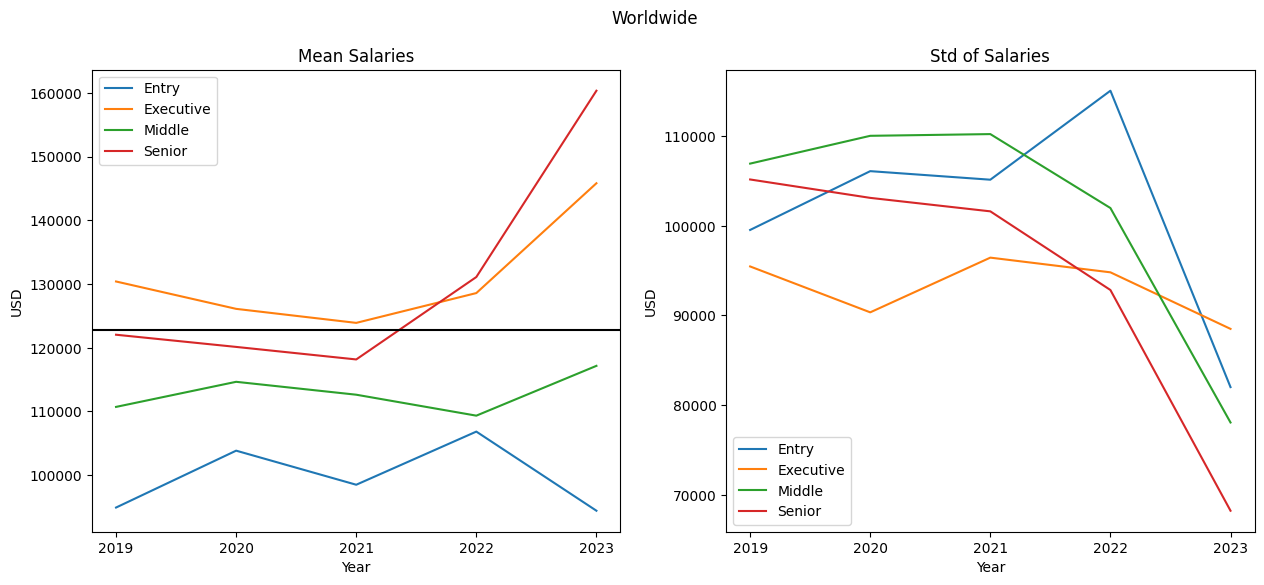

In [99]:
e_groups = experience.groupby(['year', "experience_level"])["convertedcompyearly"].agg(["mean", "median", "std"]).reset_index()
e_groups["skewness"] = 3 * (e_groups["mean"] - e_groups["median"]) / e_groups["std"]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for level in e_groups["experience_level"].unique():
    frame = e_groups[e_groups["experience_level"] == level]
    axes[0].plot(frame["year"], frame["mean"], label=level)
    axes[1].plot(frame["year"], frame["std"], label=level)

axes[0].axhline(experience["convertedcompyearly"].mean(), color='black')
axes[0].set_title("Mean Salaries")
axes[0].set_ylabel("USD")
axes[0].set_xlabel("Year")
axes[0].set_xticks([2019, 2020, 2021, 2022, 2023])
axes[1].set_title("Std of Salaries")
axes[1].set_ylabel("USD")
axes[1].set_xlabel("Year")
axes[1].set_xticks([2019, 2020, 2021, 2022, 2023])

axes[0].legend(loc="best")
axes[1].legend(loc="best")

fig.suptitle("Worldwide")
plt.show()

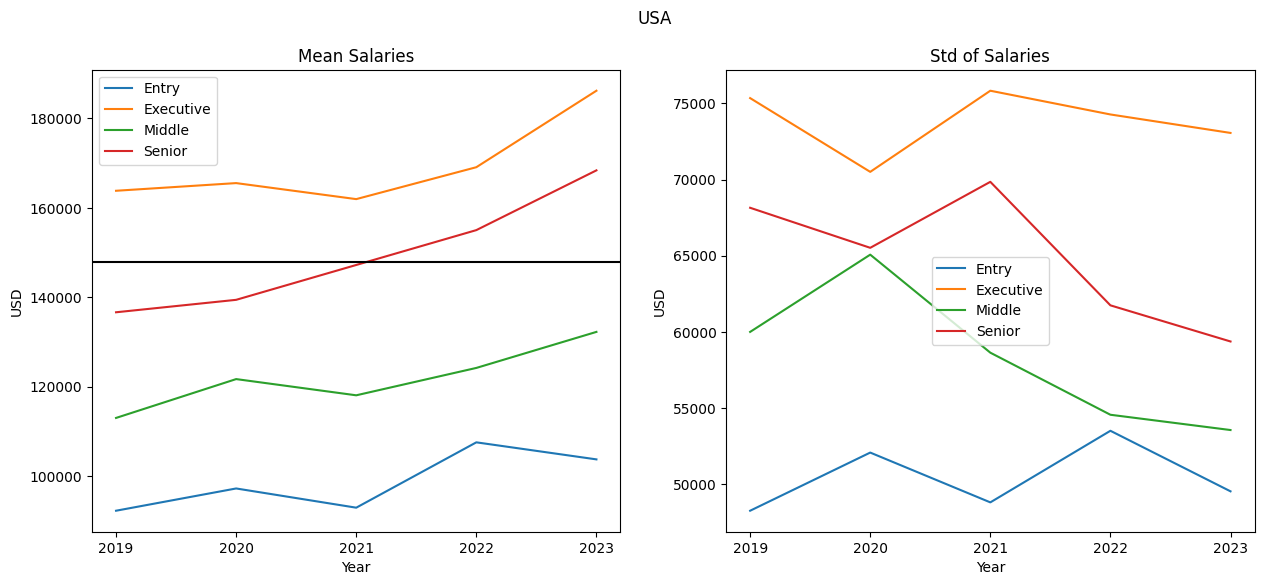

In [100]:
e_groups = experience[experience["country"] == "USA"] \
                .groupby(['year', "experience_level"])["convertedcompyearly"] \
                .agg(["mean", "median", "std"]).reset_index()
e_groups["skewness"] = 3 * (e_groups["mean"] - e_groups["median"]) / e_groups["std"]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for level in e_groups["experience_level"].unique():
    frame = e_groups[e_groups["experience_level"] == level]
    axes[0].plot(frame["year"], frame["mean"], label=level)
    axes[1].plot(frame["year"], frame["std"], label=level)

axes[0].axhline(experience[experience["country"] == "USA"]["convertedcompyearly"].mean(), color='black')
axes[0].set_title("Mean Salaries")
axes[0].set_ylabel("USD")
axes[0].set_xlabel("Year")
axes[0].set_xticks([2019, 2020, 2021, 2022, 2023])
axes[1].set_title("Std of Salaries")
axes[1].set_ylabel("USD")
axes[1].set_xlabel("Year")
axes[1].set_xticks([2019, 2020, 2021, 2022, 2023])


axes[0].legend(loc="best")
axes[1].legend(loc="best")
fig.suptitle("USA")
plt.show()

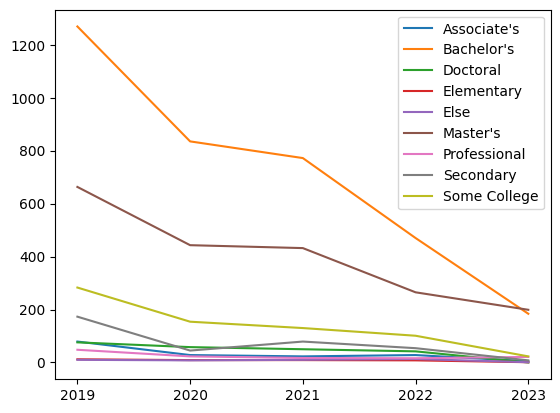

In [25]:
granular = s_o.groupby(["year", "experience_level", "edlevel"]).size().reset_index()
granular = granular[granular["edlevel"] != "nan"]
entry = granular[granular["experience_level"] == "Entry"]

for ed in entry["edlevel"].unique():
    plt.plot(entry[entry["edlevel"] == ed]["year"], entry[entry["edlevel"] == ed][0], label=ed)
plt.legend(loc="best")

Color banding higher education, anything like highschool or lower: 2 colors but different gradients.

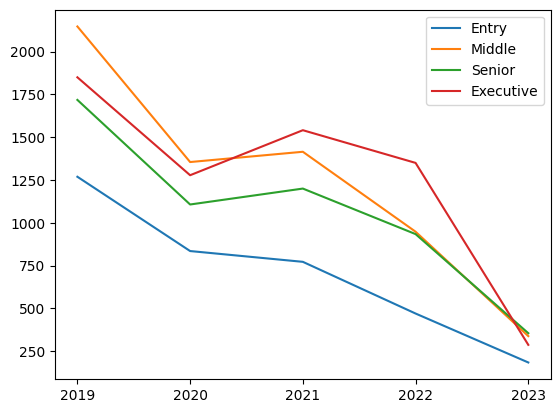

In [26]:
more_gran = s_o.groupby(["year", "edlevel", "experience_level"]).size().reset_index()
more_gran = more_gran[more_gran["edlevel"] != "nan"]
entry = more_gran[more_gran["edlevel"] == "Bachelor's"]

for exp in entry["experience_level"].unique():
    plt.plot(entry[entry["experience_level"] == exp]["year"], entry[entry["experience_level"] == exp][0], label=exp)
plt.legend(loc="best")

Cut 2023

### Between these data practitioners which skill showed up the most?
- Can we break this down further by location, or even degree or years of experience after binning?
- Can we say more skills CORRELATES to a higher salary?

In [27]:
relevant_skills = [skill for skill in skills_list if "hww" in skill]
language = [skill for skill in relevant_skills if "lg" in skill]
database = [skill for skill in relevant_skills if "db" in skill]
# platform = [skill for skill in relevant_skills if "pf" in skill]
# misctool = [skill for skill in relevant_skills if "mf" in skill]

In [28]:
# language: lg, database: db, misc tech: mt, platform: pf
s_job = pd.concat([s_o, stack_overflow[relevant_skills]], axis=1)
s_job["total_skills"] = s_job[relevant_skills].sum(axis=1)

q3 = s_job["convertedcompyearly"].quantile(0.75)
IQR = s_job["convertedcompyearly"].quantile(0.75) - s_job["convertedcompyearly"].quantile(0.25)

s_job = s_job[s_job["convertedcompyearly"] < q3 + (1.5*IQR)]

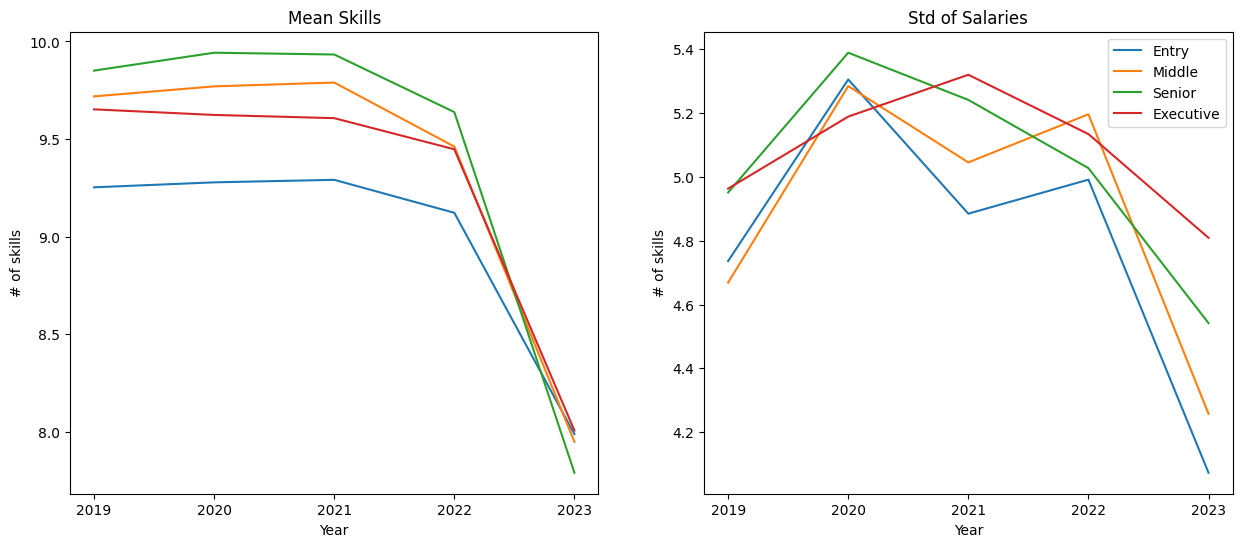

In [29]:
skill_groups = s_job.groupby(["year", "experience_level"])["total_skills"].agg(["mean", "median", pd.Series.mode, "std"]).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for level in skill_groups["experience_level"].unique():
    frame = skill_groups[skill_groups["experience_level"] == level]
    axes[0].plot(frame["year"], frame["mean"], label=level)
    axes[1].plot(frame["year"], frame["std"], label=level)

axes[0].set_title("Mean Skills")
axes[0].set_ylabel("# of skills")
axes[0].set_xlabel("Year")
# axes[0].set_xticks([2019, 2020, 2021, 2022, 2023])
axes[1].set_title("Std of Salaries")
axes[1].set_ylabel("# of skills")
axes[1].set_xlabel("Year")
# axes[1].set_xticks([2019, 2020, 2021, 2022, 2023])

plt.legend(loc="best")
plt.show()

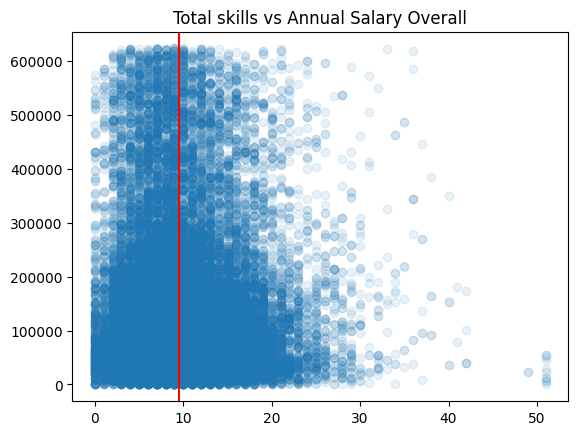

In [96]:
plt.plot(s_job["total_skills"], s_job["convertedcompyearly"], 'o', alpha=0.1)
plt.axvline(s_job["total_skills"].mean(), color='red')
plt.title("Total skills vs Annual Salary Overall");

In [71]:
lg_df = s_job[["year", "country", "convertedcompyearly"] + language]
db_df = s_job[["year", "country", "convertedcompyearly"] + database]
# not enough information for the bottom two
# pf_df = s_job[["year"] + platform]
# mt_df = s_job[["year"] + misctool]

In [72]:
# lg_df.groupby(["year", "country"]).sum()

In [73]:
top_lang = lg_df.groupby(["year", "country"]).sum().idxmax(axis=1)
# top_lang = top_lang.loc[()]

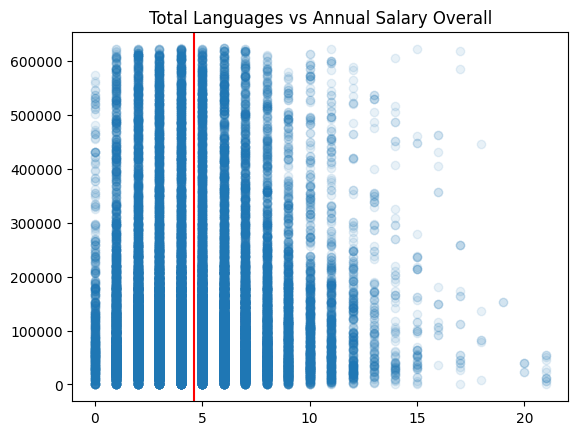

In [95]:
lg_df["total_langs"] = lg_df[language].sum(axis=1)
plt.plot(lg_df["total_langs"], lg_df["convertedcompyearly"], 'o', alpha=0.1)
plt.axvline(lg_df["total_langs"].mean(), color='red')
plt.title("Total Languages vs Annual Salary Overall");

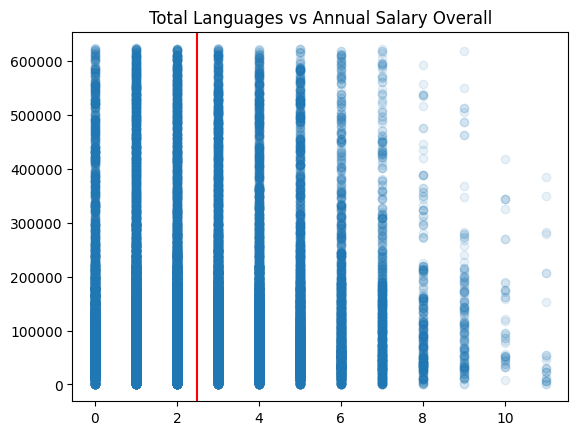

In [94]:
db_df["total_dbs"] = db_df[database].sum(axis=1)
plt.plot(db_df["total_dbs"], db_df["convertedcompyearly"], 'o', alpha=0.1)
plt.axvline(db_df["total_dbs"].mean(), color='red')
plt.title("Total Languages vs Annual Salary Overall");

Languages/DB gaining popularity?

In [33]:
# db_df.groupby("year").sum()

In [34]:
# db_df.groupby("year").sum().idxmax(axis=1)

### When we break down the data by deltas per year, what do we see?
- Percentage vs absolute?
- Number of degrees and number of experience levels?
- Salaries increasing or decreasing?

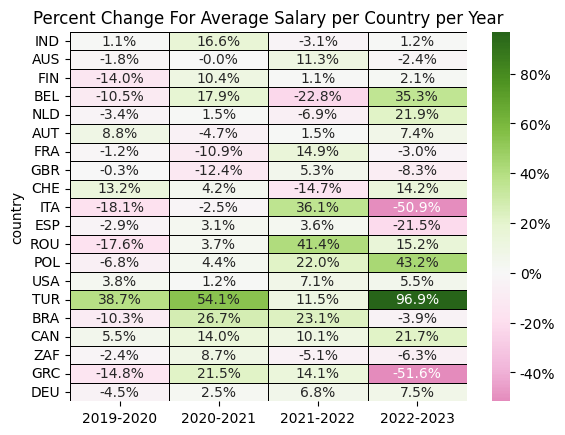

In [35]:
pivot = pd.pivot_table(location, values="convertedcompyearly", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Percent Change For Average Salary per Country per Year")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.4,  -0.2, 0, 0.2, 0.4, 0.6, 0.8])
cbar.set_ticklabels(['-40%', '-20%', '0%', '20%', '40%', '60%', '80%'])
plt.show()

Effect of COVID as a confounder

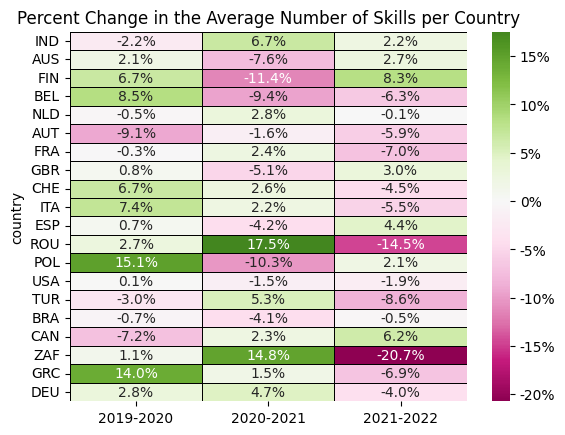

In [36]:
pivot = pd.pivot_table(s_job, values="total_skills", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)
plt.title("Percent Change in the Average Number of Skills per Country")
ax = sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.2, -0.15, -0.10, -0.05, 0, 0.05, 0.1, 0.15])
cbar.set_ticklabels(['-20%', '-15%', '-10%', '-5%', '0%', '5%', '10%', '15%'])
plt.show()

Around 0, is the key. Divergent where things *close* to 0. White not quite at 0.

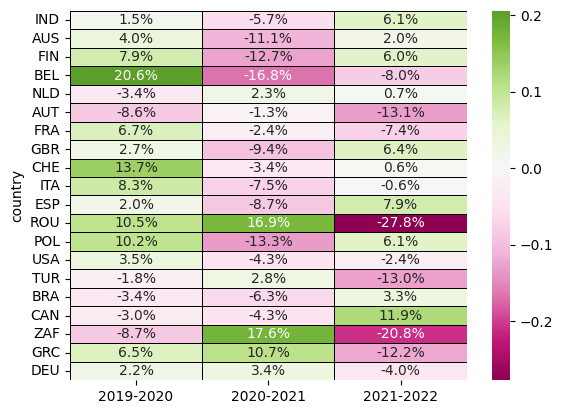

In [37]:
pivot = pd.pivot_table(s_job[s_job["lghww_Python"]==1], values="total_skills", index="country", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)

sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

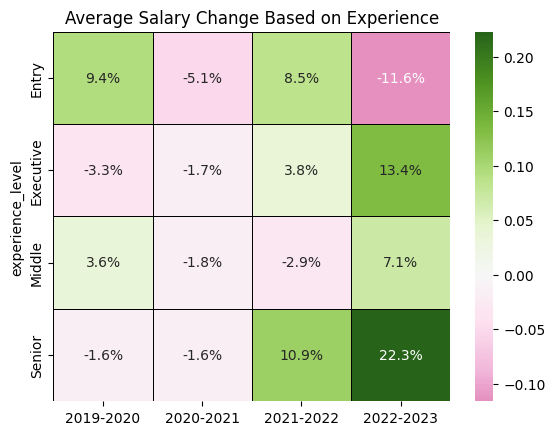

In [38]:
pivot = pd.pivot_table(experience, values="convertedcompyearly", index="experience_level", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Average Salary Change Based on Experience")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

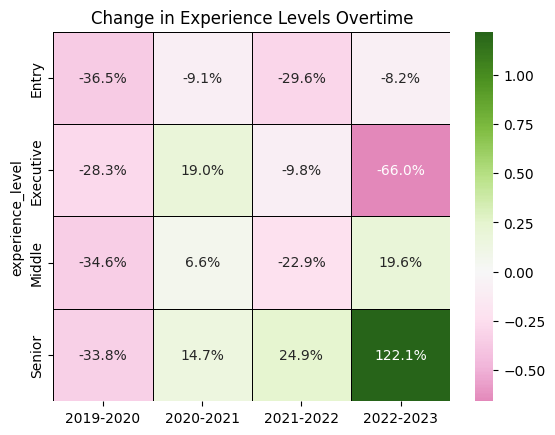

In [39]:
pivot = pd.pivot_table(experience, values="convertedcompyearly", index="experience_level", columns="year", aggfunc="count")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)

plt.title("Change in Experience Levels Overtime")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

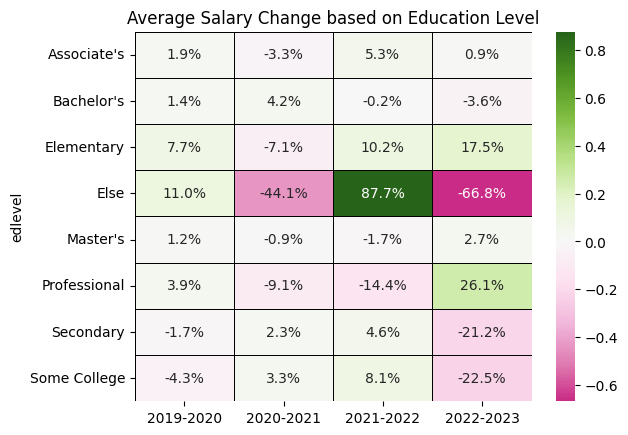

In [40]:
pivot = pd.pivot_table(s_job, values="convertedcompyearly", index="edlevel", columns="year", aggfunc="mean")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop("2019", axis=1)
plt.title("Average Salary Change based on Education Level")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

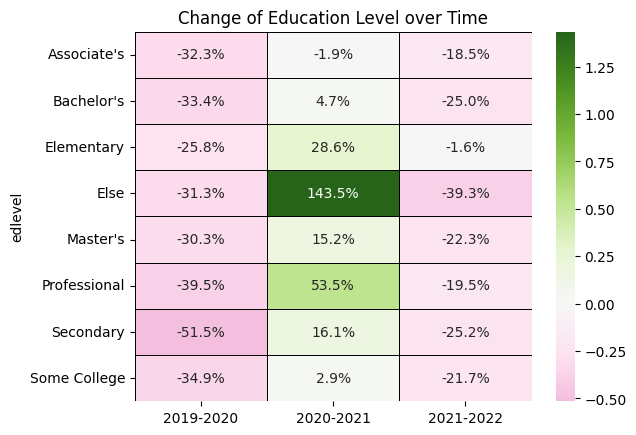

In [41]:
pivot = pd.pivot_table(s_job, values="convertedcompyearly", index="edlevel", columns="year", aggfunc="count")
pivot = pivot.dropna()
# pivot = pivot[pivot["country"].isin(countries)]
# pivot = pivot.loc[countries, :]
pivot = pivot.pct_change(axis=1)
pivot.columns = ["2019"] + [f"{int(year)-1}-{year}" for year in pivot.columns[1:]]
pivot = pivot.drop(["2019", "2022-2023"], axis=1)
plt.title("Change of Education Level over Time")
sns.heatmap(pivot, annot=True, center=0, fmt="0.01%", cmap="PiYG", linecolor='k', linewidths=0.5);

## Charts

### Choropleth Chart on Salary by Location (need)

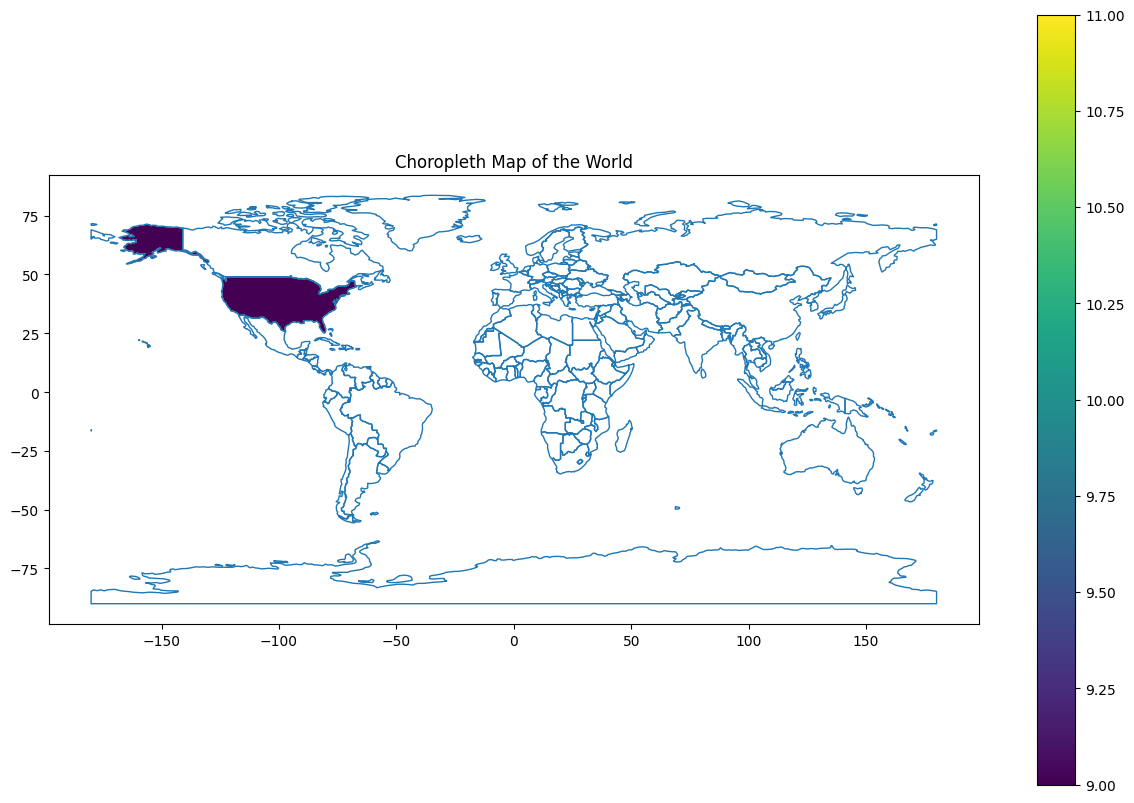

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load world countries geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example data (replace with your actual data)
data = {'Country': ['USA', 'Canada', 'Mexico', 'Brazil', 'India', 'China', 'Russia', 'Australia'],
        'Value': [10, 8, 5, 12, 15, 20, 7, 9]}

df = pd.DataFrame(data)

# Merge the world geometries with your data
world = world.merge(df, how='left', left_on='iso_a3', right_on='Country')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='Value', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Choropleth Map of the World')
plt.show()

### Line Chart of Salary by Location (need)

### Blox Plot of a Country to Show Skew if Any (need)

### Histogram of Countries with Highest Response Rates (need)

### Sunburst Plot (want)